In [12]:
import numpy as np
from numba import njit
from sklearn.metrics import accuracy_score

In [13]:
from Library.NN import Layer,Linear,RMSProp,CELoss,Dropout,L1Regularization,FlattenConv,NeuralNetwork,ReLU,Tanh,Conv2D,MaxPool2D

<h3>28x28 Digits Dataset</h3>

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

df = pd.read_csv('digits.csv')[:1_000]

X = df.drop('label',axis=1).values/255
y = df['label'].values

train_size = int(len(X)*0.8)

X_train,X_val = X[:train_size],X[train_size:]
y_train,y_val = y[:train_size],y[train_size:]

<h3>Testing Logistic Regression</h3>

In [19]:
from sklearn.linear_model import LogisticRegressionCV
lr = LogisticRegressionCV()
lr.fit(X_train,y_train)
pred = lr.predict(X_val)
print("LogisticRegression accuracy score is : " , accuracy_score(y_val,pred))

LogisticRegression accuracy score is :  0.87


(800, 1, 28, 28) (800, 1) (800, 10)
[9]


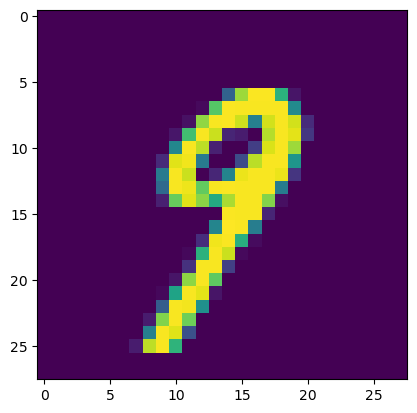

In [20]:
X = X.reshape((1_000,1,28,28))
y = y.reshape((1_000,1))

one_hot_y = np.zeros((len(y),10))
for i in range(len(y)):
    one_hot_y[i][y[i]] = 1

train_size = int(len(X)*0.8)

X_train,X_val = X[:train_size],X[train_size:]
y_train,y_val = y[:train_size],y[train_size:]
one_hot_y_train,one_hot_y_val = one_hot_y[:train_size],one_hot_y[train_size:]

print(X_train.shape,y_train.shape,one_hot_y_train.shape)
print(y_train[27])
plt.imshow(X_train[27][0])
plt.show()

<h3>8X8 Digits Dataset</h3>

In [21]:
# from sklearn.datasets import load_digits
# data = load_digits()
# X = data['data'][:]
# y = data['target'][:]


# one_hot_y = np.zeros((len(y),10))
# for i in range(len(y)):
#     one_hot_y[i][y[i]] = 1
# X = X/X.max()
# X = X.reshape((1797,1,8,8))
# train_size = int(len(X)*0.7)
# X_train,X_val = X[:train_size],X[train_size:]
# y_train,y_val = y[:train_size],y[train_size:]
# one_hot_y_train,one_hot_y_val = one_hot_y[:train_size],one_hot_y[train_size:]

# print(X_train.shape,y_train.shape,one_hot_y_train.shape)
# plt.imshow(X_train[0][0])
# plt.show()

<h3>Now lets test the convolutional NeuralNetwork</h3>

In [22]:
def train(model, X, y, optimizer, loss, epochs, print_every, batch_size=-1, return_losses=False, X_val=None, y_val=None,Decay=None):
    train_losses = [] 
    val_losses = [] 
    n = len(X)
    if batch_size == -1 or batch_size > n:
        batch_size = n
    num_batches = (n // batch_size)
    for e in range(epochs):
        epoch_loss = 0
        indices = np.arange(n)
        np.random.shuffle(indices)
        X_shuffled = X[indices].astype(float)
        y_shuffled = y[indices].astype(float)

        for i in range(0, n, batch_size):
            X_batch = X_shuffled[i:i + batch_size]
            y_batch = y_shuffled[i:i + batch_size]

            output = model.forward(X_batch)
            error = loss.loss(y_batch, output)
            epoch_loss += error

            loss.backwards()
            optimizer.step()

        epoch_loss = epoch_loss/(num_batches)
        train_losses.append(epoch_loss)

        if Decay is not None:
            Decay.step()

        if X_val is not None and y_val is not None:
            val_output = model.predict(X_val)
            val_error = loss.loss(y_val, val_output)
            val_losses.append(val_error)
            conv_pred = np.argmax(val_output,axis=1)
            
            if (e+1) % print_every == 0:
                print("Epoch:", e+1, "\tTrain Loss:", np.round(epoch_loss, 5), "\tValidation Loss:", np.round(val_error, 5), "\tValidation accuracy:",
                     np.round(accuracy_score(conv_pred,np.argmax(y_val,axis=1)),5))
        else:
            if (e+1) % print_every == 0:
                print("Epoch:", e+1, "\tTrain Loss:", np.round(epoch_loss, 5))

    if return_losses:
        if X_val is not None and y_val is not None:
            return train_losses,val_losses
        else:
            return train_losses

In [23]:
X_train.shape

(800, 1, 28, 28)

In [35]:
layers = [
    Conv2D(input_shape=(1,28,28),kernel_size=3,num_kernels=32),
    MaxPool2D(2),
    ReLU(),
    Dropout(0.7),

    Conv2D(input_shape=(32,12,12),kernel_size=3,num_kernels=64),
    MaxPool2D(2),
    ReLU(),
    Dropout(0.7),
    
    FlattenConv(),
    Linear(1_600,10)
]
NN = NeuralNetwork(layers=layers)
optim = RMSProp(NN.layers,lr=0.001)
loss = CELoss(NN.layers,apply_softmax=True,regularization=L1Regularization())

In [36]:
X_train.shape

(800, 1, 28, 28)

In [ ]:
train_losses,val_losses = train(model=NN,
               X=X_train,
               y=one_hot_y_train,
               optimizer=optim,
               loss=loss,
               epochs=100,
               print_every=1,
               batch_size=100,
               return_losses=True,
               X_val=X_val,
               y_val=one_hot_y_val)

Epoch: 1 	Train Loss: 6.37335 	Validation Loss: 3.40283 	Validation accuracy: 0.06
Epoch: 2 	Train Loss: 4.33554 	Validation Loss: 2.53126 	Validation accuracy: 0.235
Epoch: 3 	Train Loss: 3.39606 	Validation Loss: 1.92155 	Validation accuracy: 0.3
Epoch: 4 	Train Loss: 2.63861 	Validation Loss: 1.22493 	Validation accuracy: 0.45
Epoch: 5 	Train Loss: 2.12922 	Validation Loss: 0.78865 	Validation accuracy: 0.56
Epoch: 6 	Train Loss: 1.69094 	Validation Loss: 0.94599 	Validation accuracy: 0.575
Epoch: 7 	Train Loss: 1.29176 	Validation Loss: 0.84787 	Validation accuracy: 0.59
Epoch: 8 	Train Loss: 1.13226 	Validation Loss: 0.69771 	Validation accuracy: 0.635
Epoch: 9 	Train Loss: 0.90348 	Validation Loss: 0.63647 	Validation accuracy: 0.68
Epoch: 10 	Train Loss: 0.82827 	Validation Loss: 0.49403 	Validation accuracy: 0.705
Epoch: 11 	Train Loss: 0.75093 	Validation Loss: 0.38928 	Validation accuracy: 0.785
Epoch: 12 	Train Loss: 0.73781 	Validation Loss: 0.45975 	Validation accuracy: 0.

<h3>The convolutional model after 26 epochs reached 0.955 accuracy on the validation set while the logistic regression model got only 0.87</h3>